 **High-Frequency (Cypto price) trading rules using Machine Learning**
 
 Version 2.0
 
 Momentum strategy + Meta-Labeling


1. Financial Data and Bars 
 - OHLCV Bar
 - Summary and plot


2. Getting Trend Signals (Long only)
 - RSI with different windows


3. Labeling with Triple-Barrier Method
 - Form Symmetric Triple Barrier with signals
 - Binary Labeling (Profit or Loss)


4. Secondary Model

 4.1. Features (X)
 - Market/ Microstructure features/ Fundamentals/ Sentiments/ 
 - Feature Scaling (MinMaxScaler)
 - Feature Engineering (PCA/ Autoencoder)
 
 4.2. Prediction Model
 - Cross-Validation/ Simple Split
 - AutoML with *autogluon* and select the best model
 - Results
 
 4.2. Trading
 - Bet Sizing
 
 
5. Results
 - Cumulative returns, Sharpe Ratio, Drawdown


In [1]:
# De Prado AMFL
import triple_barrier as tb

# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from scipy.stats import norm, moment

#feature
from sklearn import preprocessing
from sklearn.decomposition import PCA 

# CV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.model_selection import cross_val_score, cross_val_predict

#ML
import autogluon as ag


# Technical analysis
import ta
import getTA #local
import tautil #local

# Backtesting pyfolio
import pyfolio as pf

C:\Users\JHCho\anaconda3\envs\py37\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
def figure_scatter(sc,close, title, cmap='bwr', figsize=(15,5)):
    plt.figure(figsize=figsize)
    plt.plot(close, linewidth=0.5,alpha=0.6)
    plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap=cmap, alpha=1)
    plt.colorbar()
    plt.title(title)
    plt.savefig('image/{}.png'.format(title))
    plt.show()

# 1. Financial Data and Bars

## OHLCV Bar

- ETH/USD 
- 5 minutes OHLCV(open, high, low, close, volume)

In [4]:
df_raw = pd.read_csv('ethusd5min.csv')
df = df_raw.set_index('timestamp')
df.index = pd.to_datetime(df.index)

In [5]:
df

,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2019-01-01 00:00:00,131.45,131.54,131.01,131.27,1269.12705,1546301099999,1.666154e+05,404,583.71526,7.665267e+04,0
2019-01-01 00:05:00,131.26,131.35,131.12,131.29,1601.91843,1546301399999,2.102706e+05,329,970.39345,1.273754e+05,0
2019-01-01 00:10:00,131.27,131.36,131.19,131.31,560.54337,1546301699999,7.359844e+04,255,237.78679,3.121957e+04,0
2019-01-01 00:15:00,131.30,131.36,131.25,131.30,651.89505,1546301999999,8.559326e+04,203,173.81466,2.282429e+04,0
2019-01-01 00:20:00,131.26,131.44,131.25,131.28,500.58218,1546302299999,6.572714e+04,275,232.22948,3.049598e+04,0
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-13 23:40:00,1941.97,1943.71,1940.34,1943.25,392.24754,1626219899999,7.618761e+05,925,265.19319,5.150956e+05,0
2021-07-13 23:45:00,1943.24,1943.24,1932.66,1933.79,1233.82503,1626220199999,2.389417e+06,2173,612.61804,1.186551e+06,0
2021-07-13 23:50:00,1933.79,1935.73,1931.38,1933.40,1011.00253,1626220499999,1.954553e+06,1957,498.29748,9.634496e+05,0


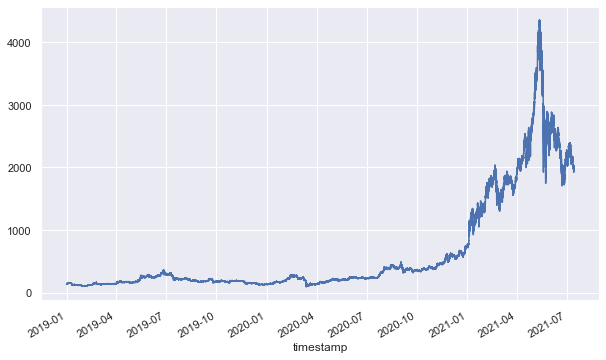

In [212]:
df.close.plot(figsize=(10,6))

In [217]:
# after 2021, there's huge updowns.
df = df.loc[:'2020-12':,:]

In [218]:
close = pd.to_numeric(df.close)
open = pd.to_numeric(df.open)
high = pd.to_numeric(df.high)
low = pd.to_numeric(df.low)
volume = pd.to_numeric(df.volume)
buy_volume = pd.to_numeric(df.tb_base_av)

## summary & plots

In [219]:
df_ohlcv = pd.DataFrame([open,high,low,close,volume]).T
df_ohlcv.describe()

,open,high,low,close,volume
count,209927.000000,209927.000000,209927.000000,209927.000000,209927.000000
mean,243.492061,243.887416,243.077421,243.494881,2190.583501
std,124.212462,124.446560,123.957276,124.216585,3165.919805
min,88.440000,93.590000,86.000000,88.350000,0.000000
25%,159.900000,160.120000,159.630000,159.900000,641.117305
50%,203.780000,204.150000,203.400000,203.780000,1258.037530
75%,278.355000,279.145000,277.605000,278.345000,2488.947350
max,754.980000,758.740000,753.500000,754.970000,105591.963390


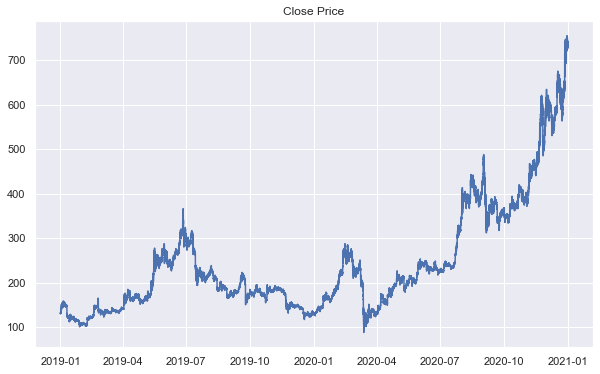

In [220]:
plt.figure(figsize=(10,6))
plt.title('Close Price')
plt.plot(close)
plt.savefig('image/close_price.jpg')
plt.show();

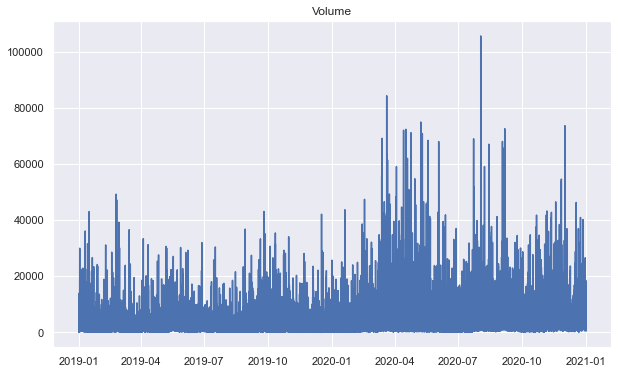

In [221]:
plt.figure(figsize=(10,6))
plt.title('Volume')
plt.plot(volume)
plt.savefig('image/volume.jpg')
plt.show();

In [222]:
of = buy_volume - (volume-buy_volume)

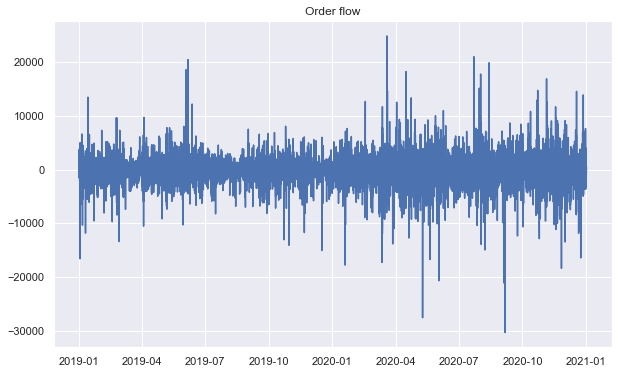

In [223]:
plt.figure(figsize=(10,6))
plt.title('Order flow')
plt.plot(of)
plt.savefig('image/order_flow.jpg')
plt.show();

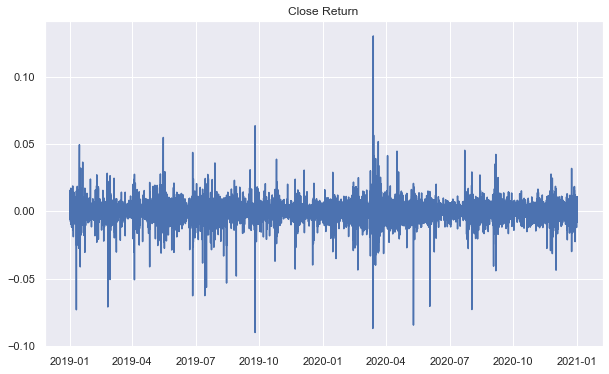

In [224]:
plt.figure(figsize=(10,6))
plt.title('Close Return')
plt.plot(close.pct_change())
plt.savefig('image/closereturn.jpg')
plt.show();

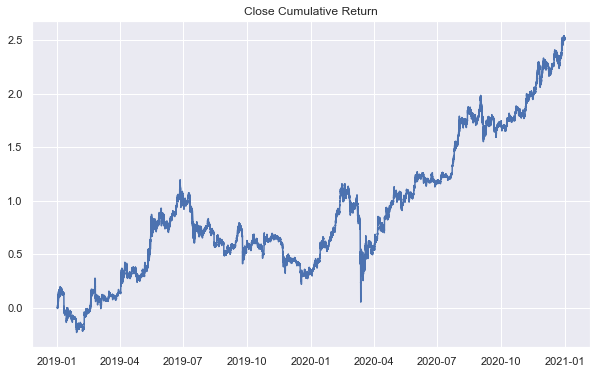

In [225]:
plt.figure(figsize=(10,6))
plt.title('Close Cumulative Return')
plt.plot(np.cumsum(close.pct_change()))
plt.savefig('image/closecumreturn.jpg')
plt.show();

# 2. Getting Trend Signals

 
 I considered only long (up-trend) side.
 
 It is not difficult to do the other side.

In [226]:
windows = np.arange(10,210,10)

For example, let's see the RSI(relative strength index), which is the momentum indicator

I made the threshold to choose when to long or short. 

In [227]:
rsi_df = pd.DataFrame(index=df.index)

In [228]:
for w in windows:
    rsi_df['rsi_{}'.format(w)] = tautil.my_rsi_2(close, w)
rsi_df.dropna(inplace=True)

In [229]:
rsi_df

,rsi_10,rsi_20,rsi_30,rsi_40,rsi_50,rsi_60,rsi_70,rsi_80,rsi_90,rsi_100,rsi_110,rsi_120,rsi_130,rsi_140,rsi_150,rsi_160,rsi_170,rsi_180,rsi_190,rsi_200
timestamp,,,,,,,,,,,,,,,,,,,,
2019-01-01 20:40:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2019-01-01 20:45:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2019-01-01 20:50:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2019-01-01 20:55:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2019-01-01 21:05:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-28 09:15:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-12-28 09:20:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-12-28 09:25:00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


rsi(14) is often adopted in daily data.

Here is 5 minutes data.

And we have to consider this is crypto data which is far more volatile.


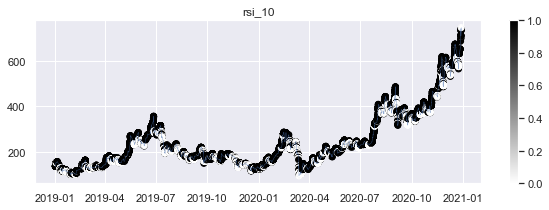

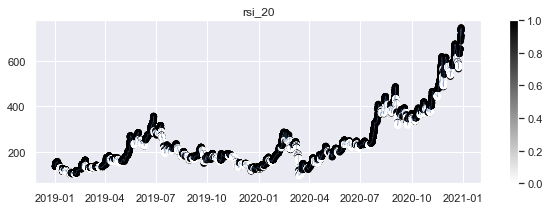

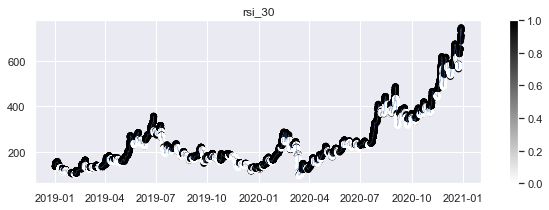

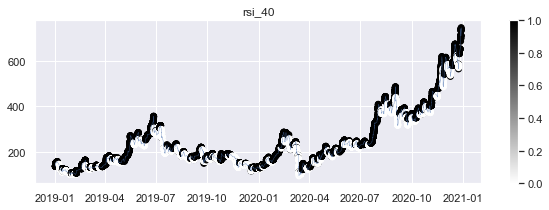

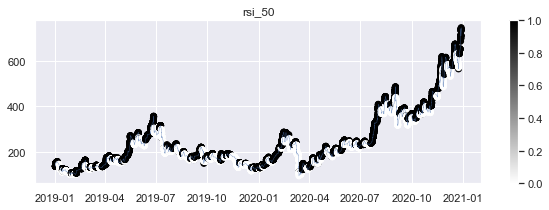

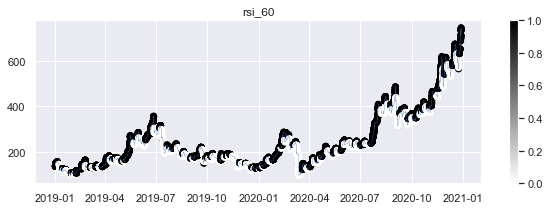

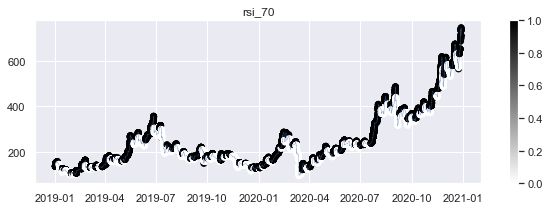

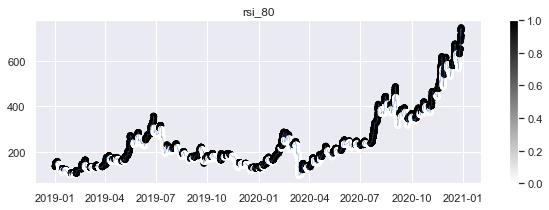

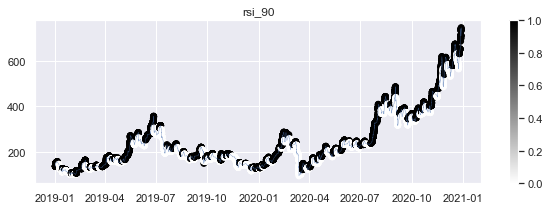

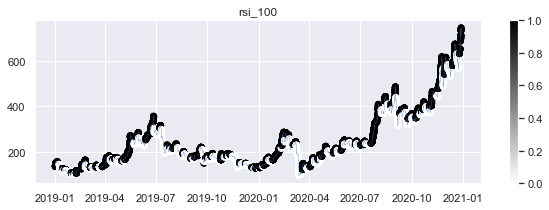

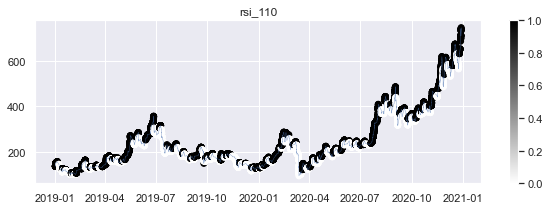

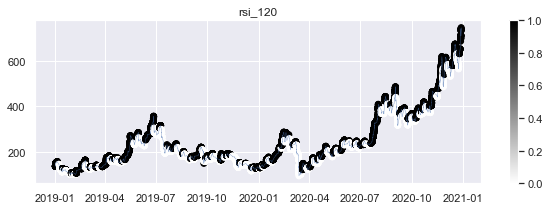

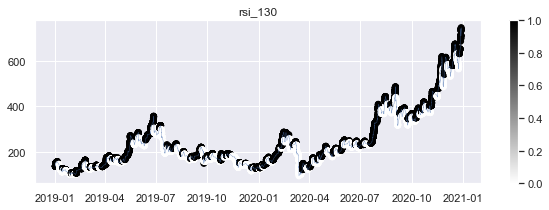

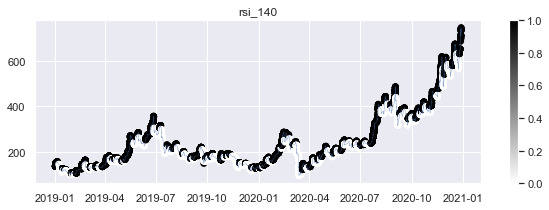

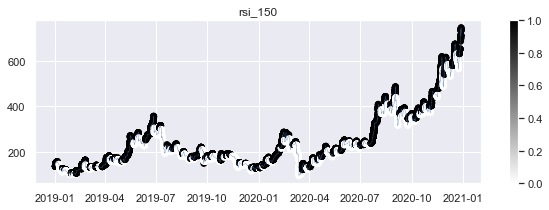

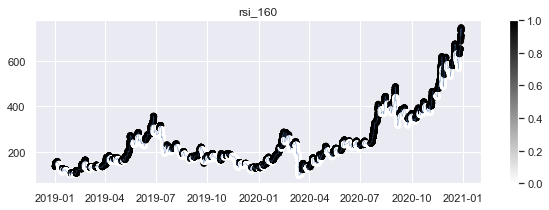

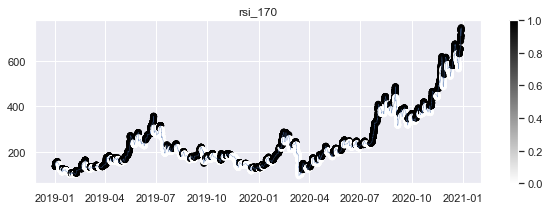

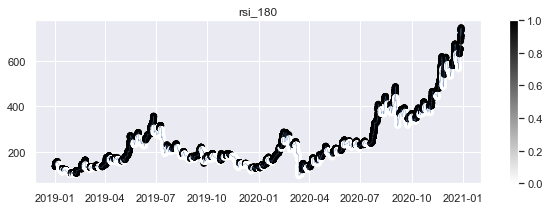

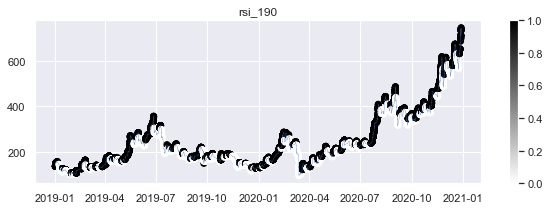

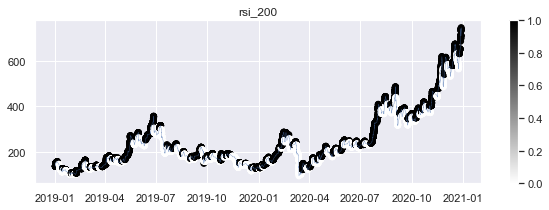

In [230]:
# long signals

for i in rsi_df.columns:
    sc = rsi_df[i].copy()
    plt.figure(figsize=(10,3))
    plt.plot(close.loc[sc.index], linewidth=0.5,alpha=0.6)
    plt.scatter(close.loc[sc.index].index, close.loc[sc.index], c=sc,cmap='gray_r', alpha=1, vmin=0,vmax=1)
    plt.colorbar()
    plt.title('{}'.format(i))
    plt.show()

## 3. Labeling with Triple-Barrier Method
 ### Form Symmetric Triple Barrier with signals
 

Below is for testing various windows.

In [231]:
#returns_df = pd.DataFrame()

#for rsi_w in rsi_df.columns:
#    long = rsi_df.loc[rsi_df[rsi_w]==1,rsi_w]
#    enter = long.index
#    pt_sl = [0.05,0.05] # profit-taking, stop-loss target
#    max_holding = [3,0] #[day,hours]
#    barrier = tb.get_barrier(close,enter,pt_sl,max_holding=max_holding,target=None)
#    returns_df['ret_{}'.format(rsi_w)] = barrier.ret

In [232]:
#for r in returns_df.columns:
#    ret = returns_df[r].dropna()
#    # Intended symmetric returns
#    plt.figure(figsize=(10,6))
#    plt.title('Symmetric returns of Primary Model')
#    plt.bar(ret.index, ret.dropna(),linewidth=0)
#    #plt.savefig('return_of_1stmodel.jpg')
#    plt.show();

In [233]:
#returns_df.cumsum()

For simplicity, I will choose rsi window = 100 for this asset and interval.

You can use other methods, for example combining with MACD.


In [234]:
rsi_w = 'rsi_100'
long = rsi_df.loc[rsi_df[rsi_w]==1,rsi_w]
enter = long.index
pt_sl = [0.05,0.05] # profit-taking, stop-loss target
max_holding = [14,0] #[day,hours]
barrier = tb.get_barrier(close,enter,pt_sl,max_holding=max_holding,target=None)

Make triple barrier using long signals, profit-taking/stop-loss target returns (must be symmetric), and maximum holding period.

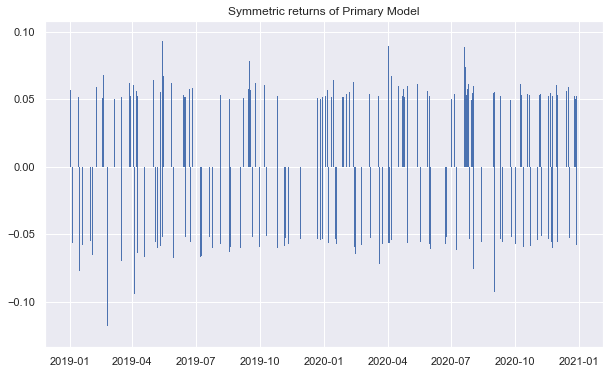

In [235]:
ret = barrier.ret
plt.figure(figsize=(10,6))
plt.title('Symmetric returns of Primary Model')
plt.bar(ret.index, ret.dropna(),linewidth=0)
plt.savefig('image/returns_of_1stmodel.jpg')
plt.show();

You can see the symmetric returns, except for those who exceed max holding periods. 

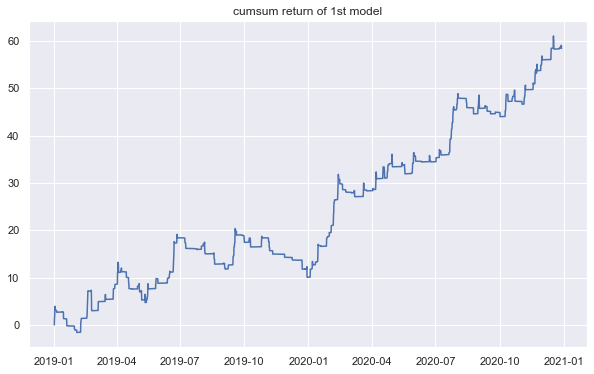

In [236]:
plt.figure(figsize=(10,6))
plt.title('cumsum return of 1st model')
plt.savefig('image/cumsum_return_1stmodel.jpg')
plt.plot(ret.cumsum())
plt.show()

### Binary Labeling (Profit or Loss)

In [237]:
first_model = pd.DataFrame()
first_model['y_pred'] = long
first_model['y_true'] = np.sign(long*barrier.ret)
first_model = first_model.dropna()

y_pred1 = first_model.y_pred
y_true1 = first_model.y_true

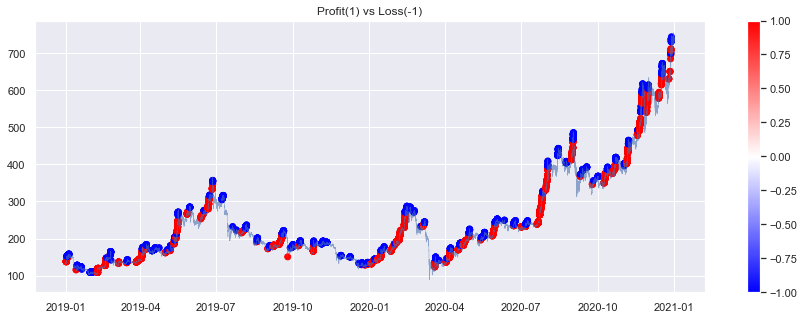

In [238]:
sc = y_true1
title = 'Profit(1) vs Loss(-1)'
figure_scatter(sc,close, title, cmap='bwr', figsize=(15,5))

In [239]:
pnllabel = y_true1.loc[y_true1!=0]
pnllabel.value_counts()

 1.0    2927
-1.0    1673
Name: y_true, dtype: int64

In [240]:
print('Probability of winning: ',pnllabel.value_counts().values[0] / pnllabel.value_counts().values.sum())

Probability of winning:  0.6363043478260869


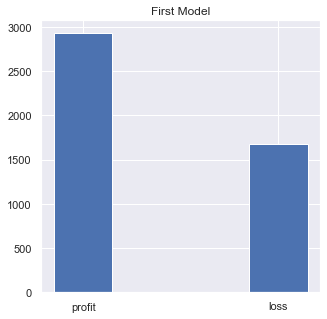

In [241]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],pnllabel.value_counts(), width=0.3)
plt.title('First Model')
plt.savefig('image/pnl_first_model.jpg')
plt.show()

## 4. Secondary Model

 ### 4.1. Features (X)
 ####  Market data

Market
- Techincal indicators with market data

In [242]:
df_ = df_ohlcv

I'll choose these features

from the experiment that i've done.

link

In [252]:
# i did rsi_100 instead of rsi_14 in first model. So I will multiply 8 to each of windows.
mt=10 #multiplier

rsi = ta.momentum.rsi(close,14*mt).rename('rsi_14')
stoch_diff = (ta.momentum.stoch(high,low,close,14*mt) - ta.momentum.stoch_signal(high,low,close,14*mt)).rename('stoch_diff_14_3')
macd_diff = ta.trend.macd_diff(close,26*mt,12*mt,10).rename('macd_diff_26_12_9')
dpo = ta.trend.dpo(close,20*mt).rename('dpo_20')
aroon = ta.trend.AroonIndicator(close,25*mt).aroon_indicator().rename('aroon_25')
mfv = (volume* ((close - low) - (high - close)) /(high - low)).rename('mfv')
eom_1 = ta.volume.ease_of_movement(high,low,volume,1*mt).rename('eom_1')
mfi = ta.volume.money_flow_index(high,low,volume,14*mt).rename('mfi_14')
fi_1 = ta.volume.force_index(close,volume,1*mt).rename('fi_1')

In [253]:
TA = pd.DataFrame([rsi,stoch_diff,macd_diff,dpo,aroon,mfv,eom_1,mfi,fi_1]).T

In [254]:
mkt = TA.copy()

for i in [1,5,10,20]:
    mkt = mkt.join(volume.diff(i).rename('vol_mom_{}'.format(i)))
    mkt = mkt.join(of.diff(i).rename('of_mom_{}'.format(i)))
    mkt = mkt.join(close.diff(i).rename('mom_{}'.format(i)))
    
for i in [5,20]:
    mkt = mkt.join(close.rolling(i).std().rename('std_{}'.format(i)))
    mkt = mkt.join(volume.rolling(i).std().rename('vol_std_{}'.format(i)))
                   

corr = mkt.corr()
#corr.style.background_gradient(cmap='coolwarm').set_precision(2)

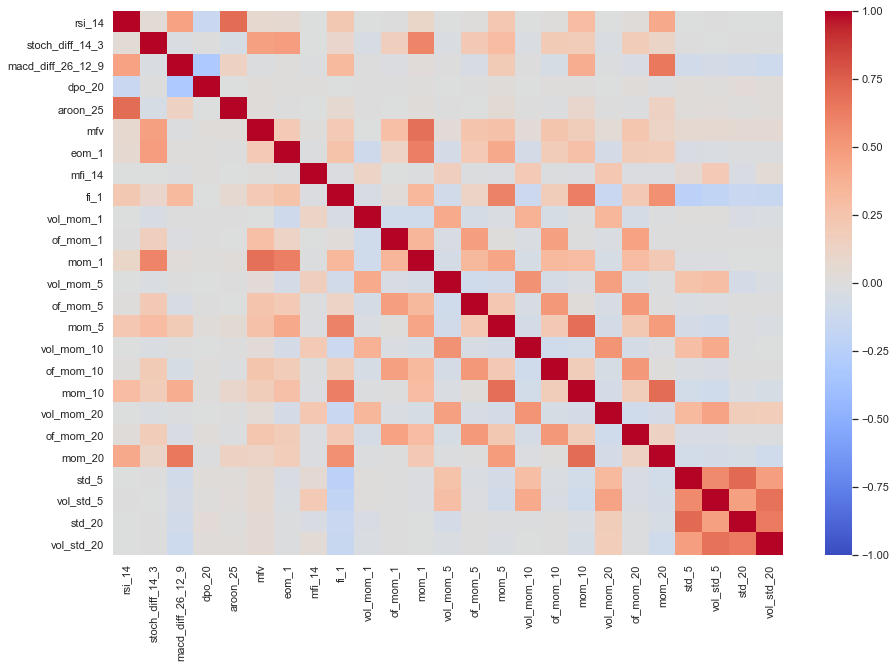

In [255]:
plt.figure(figsize=(15,10))
sns.heatmap(corr, cmap='coolwarm', vmin=-1,vmax=1)
plt.savefig('image/feature_corr.png')
plt.show()

You can use all features, but I remove some features that are highly linearly correlated.

In [262]:
# Highly correlated market features

h = 0.8
where = (abs(corr)>h) & (corr<1)

hc_list =[]
for i in range(len(np.where(where)[0])):
    hc_list.append(sorted([corr.columns[np.where(where)[0][i]], corr.columns[np.where(where)[1][i]]]))
hc_list = np.array(sorted(hc_list))
hc_list

array([], dtype=float64)

In [263]:
drop_features = np.unique(hc_list[:,1])
drop_features

IndexError: too many indices for array

In [264]:
mkt1 = mkt.drop(columns=drop_features)
corr2 = mkt1.corr()

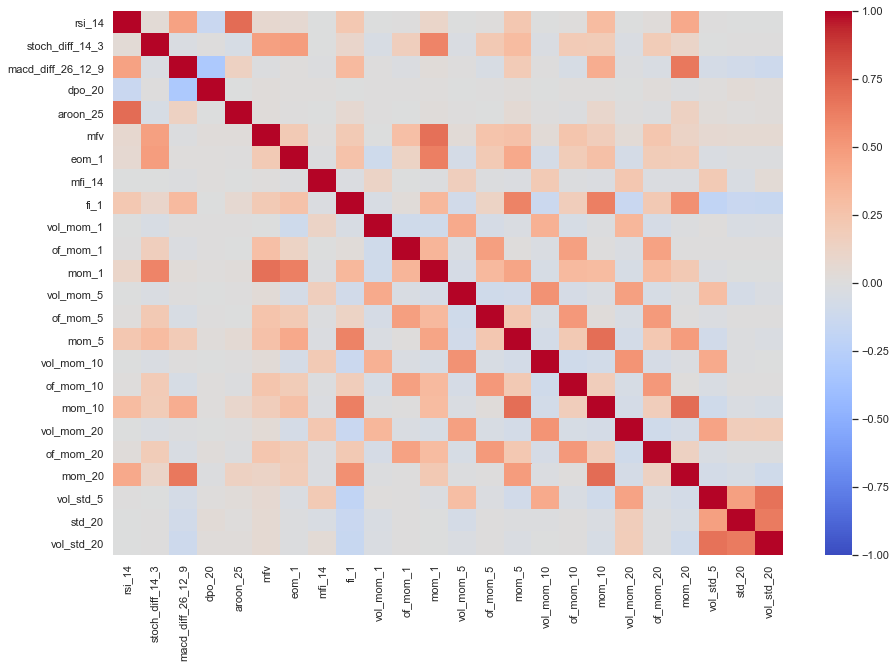

In [265]:
plt.figure(figsize=(15,10))
sns.heatmap(corr2, cmap='coolwarm', vmin=-1,vmax=1)
plt.savefig('image/feature_corr2.png')
plt.show()

#### Market Microstructures

We don't have tick data to build microstructure features.

It would be very helpful with that data.

#### Fundamentals

It is not easy to get fundamental data for 5 minutes Ethereum price.

#### Sentiments

We can get features from Natural Language Process.

Working on this.

#### Feature Scaling

 
minmax

In [269]:
raw_X = mkt1.shift(1).dropna().copy()

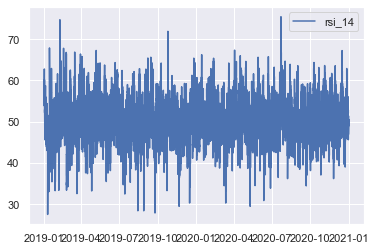

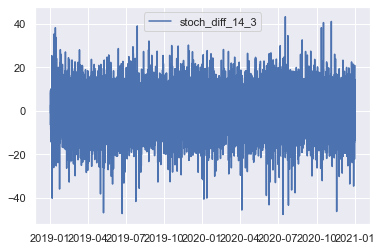

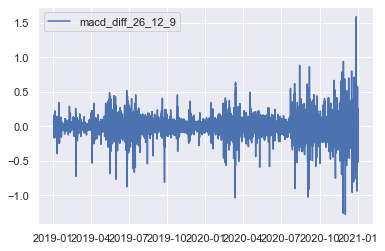

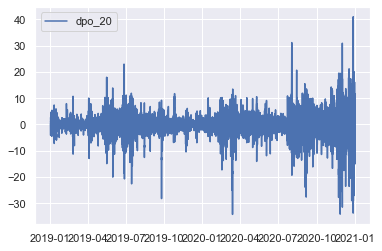

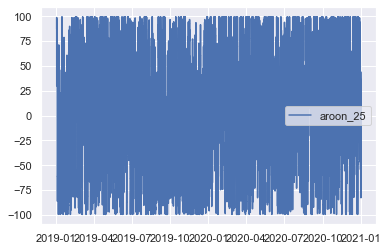

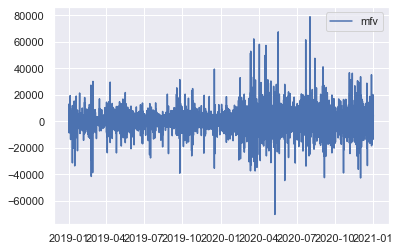

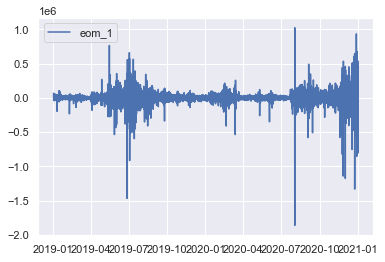

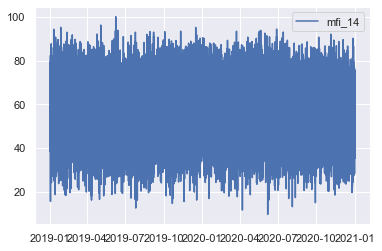

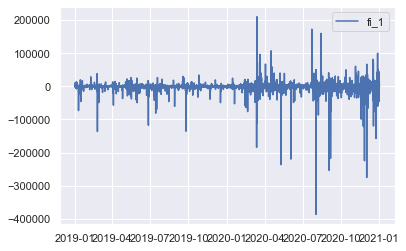

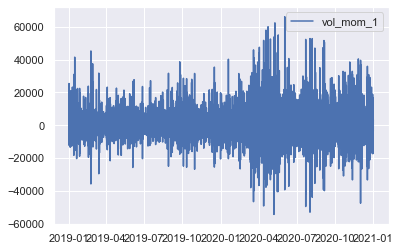

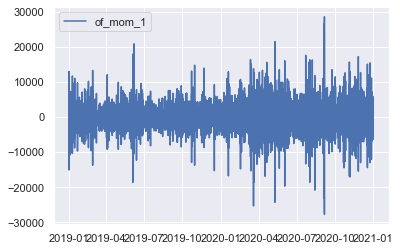

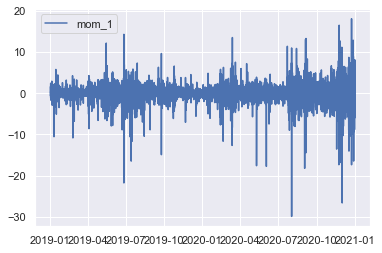

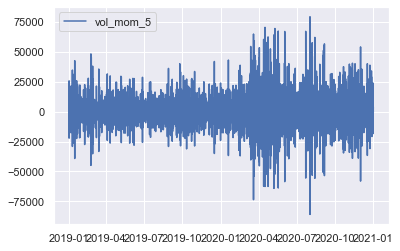

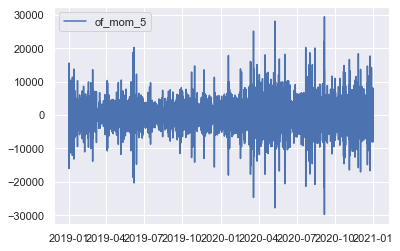

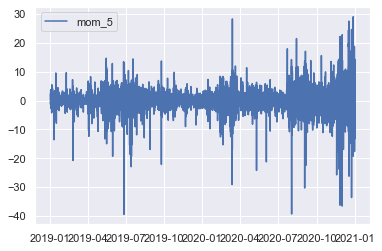

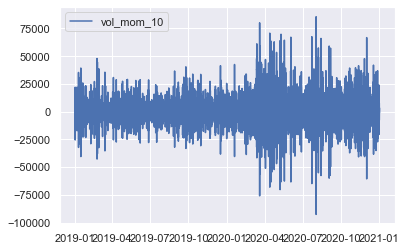

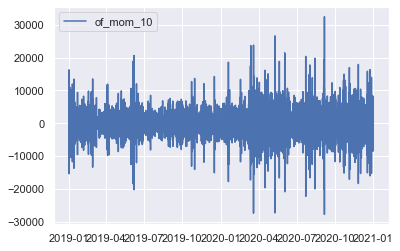

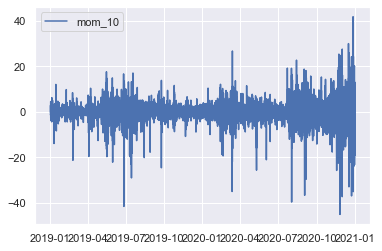

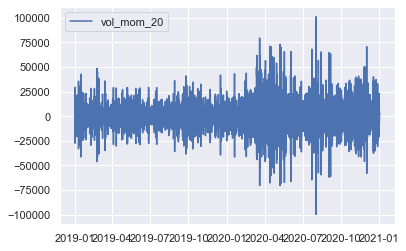

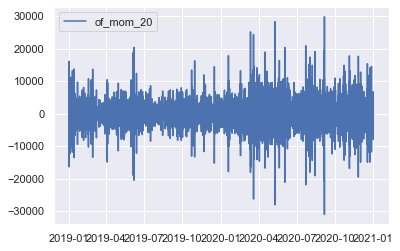

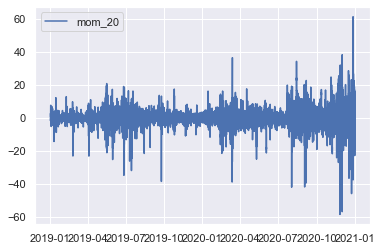

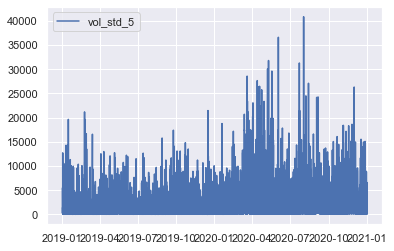

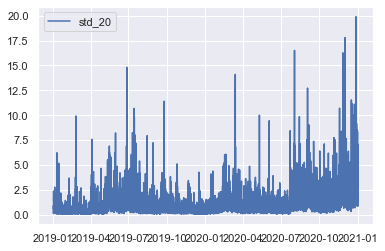

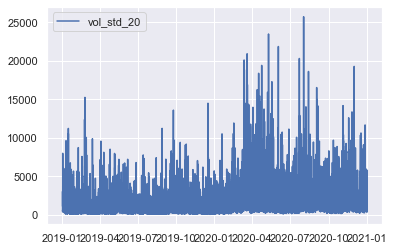

In [271]:
for i in raw_X.columns:
    plt.figure()
    plt.plot(raw_X[i])
    plt.legend([i])

In [272]:
scaler = preprocessing.MinMaxScaler((0,1))
scaler.fit(raw_X)
raw_X_scaled = scaler.transform(raw_X)

scaled_X = pd.DataFrame(raw_X_scaled,index=raw_X.index,columns=raw_X.columns)

#### Feature Selection
- Autoencoder (in process) - non-linear

CNN-autoencoder

https://github.com/jo-cho/machine-learning-for-trading/blob/master/18_convolutional_neural_nets/07_cnn_for_trading.ipynb

- PCA - linear

In [273]:
# PCA

n=10
pca = PCA(n)
pca.fit(scaled_X)
X_pca = pca.transform(scaled_X)

pca_X = pd.DataFrame(X_pca, index=scaled_X.index)
pca_X

,0,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,,
2019-01-01 22:25:00,-0.426757,-0.080272,-0.009765,-0.008724,0.013107,-0.006054,-0.020325,-0.001170,0.005561,-0.007300
2019-01-01 22:30:00,-0.425719,-0.146876,0.000045,-0.010941,0.006733,-0.021156,-0.019370,0.004605,0.002972,-0.004314
2019-01-01 22:35:00,-0.424520,-0.187028,0.006364,-0.021169,0.024915,-0.014966,-0.022719,-0.004754,0.012399,0.007687
2019-01-01 22:40:00,-0.429115,-0.094684,-0.008646,0.020890,-0.057162,-0.027458,-0.022605,0.008015,0.012684,-0.013375
2019-01-01 22:45:00,-0.427152,-0.085556,-0.019998,-0.001004,-0.012382,-0.007834,-0.007049,0.011032,-0.012341,0.006884
...,...,...,...,...,...,...,...,...,...,...
2020-12-31 23:35:00,0.196511,0.101295,-0.045078,0.032850,0.047325,-0.039392,0.039637,0.052146,0.016704,0.005824
2020-12-31 23:40:00,0.198009,0.177247,-0.050511,0.018078,0.058232,-0.047343,0.038060,0.070326,0.014479,0.001966
2020-12-31 23:45:00,0.201547,0.165811,-0.043415,-0.022369,0.133675,-0.057718,0.038325,0.094784,0.009043,0.004808


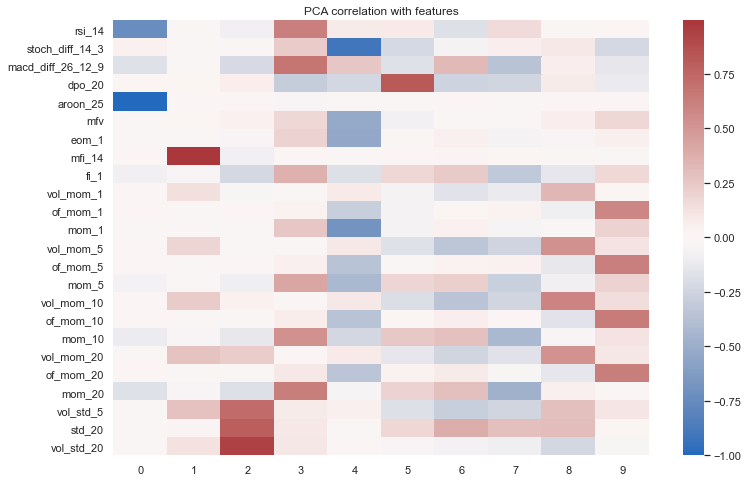

In [274]:
integrated_X = scaled_X.join(pca_X)
corr = integrated_X.corr().where(np.tril(np.ones(integrated_X.corr().shape)).astype(np.bool)).iloc[-n:,:-n].T
f = plt.figure(figsize=(12, 8))
sns.heatmap(corr,cmap='vlag',vmin=-1)
plt.title('PCA correlation with features')
plt.savefig('image/pcacorr.jpg')
plt.show();

### 4.2. Prediction Model

#### Cross-Validation/ Simple Split

To train and test, you need to take account cross-validation.



In [275]:
y = pnllabel.copy().rename('y')

In [276]:
tmp_data = pca_X.copy() # or pca_X
tmp_data = tmp_data.join(y)
tmp_data.dropna(inplace=True)

X2 = tmp_data.iloc[:,:-1]
y2 = tmp_data.iloc[:,-1]

In [278]:
train_data = tmp_data.loc[:'2020-4-1',:]
test_data = tmp_data.loc['2020-4-1':,:]

#### AutoML with autogluon and select the best model

In [279]:
from autogluon.tabular import TabularPredictor

We have to focus on **precision score**

because

<Increasing p (probability of winning)>
- from first strategy, we get $p = \frac{P}{P+L}$
- after training and predicting the PnL points, we drop predicted loss points (TN+FP),
thus we get $\hat{p} =  \frac{P-FL}{(P-FL) + (L-TL)} = \frac{TP+FL-FL}{(TP+FL-FL) + (TL+FP-TL)} = \frac{TP}{TP+FP}$
, which is the precision score of 2nd model.

- If $\hat{p}>p$, this helps.

This *autogluon* supports a number of machine learning models, and automatically chooses optimal hyperparameters given which score to be optimized.

So we choose precision score to be maximized. (but there are some problems with *n*(annual betting opportuinites).)

or F1 socre (*suggested by De Prado): Accuracy may not be an adequate classification score for meta-labeling
applications. Suppose that, after you apply meta-labeling, there are many more
negative cases (label ‘0’) than positive cases (label ‘1’). Under that scenario, a
classifier that predicts every case to be negative will achieve high accuracy, even
though recall=0 and precision is undefined. The F1 score corrects for that flaw,
by assessing the classifier in terms of the (equally weighted) harmonic mean of
precision and recall,

In [280]:
predictor = TabularPredictor(label='y', eval_metric='f1').fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20210719_181234\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20210719_181234\"
AutoGluon Version:  0.2.0
Train Data Rows:    2630
Train Data Columns: 10
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1.0, -1.0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1.0, class 0 = -1.0
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive (1.0) vs negative (-1.0) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or specify positive_class in Predictor init.
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipe

[03:12:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


	0.8518	 = Validation f1 score
	1.31s	 = Training runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetMXNet ...
		Unable to import dependency mxnet. A quick tip is to install via `pip install mxnet --upgrade`, or `pip install mxnet_cu101 --upgrade`
Fitting model: LightGBMLarge ...
	0.8698	 = Validation f1 score
	3.96s	 = Training runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	0.8742	 = Validation f1 score
	1.15s	 = Training runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 18.12s ...
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20210719_181234\")


In [281]:
result = predictor.leaderboard(test_data, silent=True)
result

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesEntr,0.723790,0.850214,0.143851,0.106977,0.313261,0.143851,0.106977,0.313261,1,True,9
1,ExtraTreesGini,0.716334,0.834532,0.150361,0.106711,0.310166,0.150361,0.106711,0.310166,1,True,8
2,WeightedEnsemble_L2,0.706012,0.874233,0.178125,0.123864,5.123025,0.007983,0.001995,1.151922,2,True,13
3,RandomForestEntr,0.696383,0.833333,0.126661,0.121717,0.515656,0.126661,0.121717,0.515656,1,True,6
4,LightGBMLarge,0.692193,0.869832,0.047872,0.013963,3.963099,0.047872,0.013963,3.963099,1,True,12
5,RandomForestGini,0.683469,0.840841,0.134778,0.122349,0.443125,0.134778,0.122349,0.443125,1,True,5
6,CatBoost,0.676636,0.856707,0.004986,0.002992,1.808334,0.004986,0.002992,1.808334,1,True,7
7,LightGBMXT,0.671858,0.829493,0.013963,0.004987,2.092405,0.013963,0.004987,2.092405,1,True,3
8,LightGBM,0.669711,0.846875,0.008975,0.006981,1.503980,0.008975,0.006981,1.503980,1,True,4
9,KNeighborsUnif,0.669697,0.779970,0.107384,0.128441,0.005984,0.107384,0.128441,0.005984,1,True,1


#### Results

In [282]:
best_model = result.model[0]

In [283]:
y_true2 = test_data.y
y_pred2 = predictor.predict(test_data, model=best_model)

print("Predictions:  \n", y_pred2)
perf = predictor.evaluate_predictions(y_true=y_true2, y_pred=y_pred2, auxiliary_metrics=True)

Evaluation: f1 on test data: 0.7237896203413445
Evaluations on test data:
{
    "f1": 0.7237896203413445,
    "accuracy": 0.5952016334864727,
    "balanced_accuracy": 0.4990223685756884,
    "mcc": -0.0023756403042318945,
    "precision": 0.6538703587161737,
    "recall": 0.8104524180967239
}


Predictions:  
 timestamp
2020-04-02 00:15:00    1.0
2020-04-02 00:20:00    1.0
2020-04-02 00:25:00   -1.0
2020-04-02 00:30:00    1.0
2020-04-02 00:40:00    1.0
                      ... 
2020-12-28 09:15:00   -1.0
2020-12-28 09:20:00   -1.0
2020-12-28 09:25:00    1.0
2020-12-28 09:40:00   -1.0
2020-12-28 16:15:00   -1.0
Name: y, Length: 1959, dtype: float64


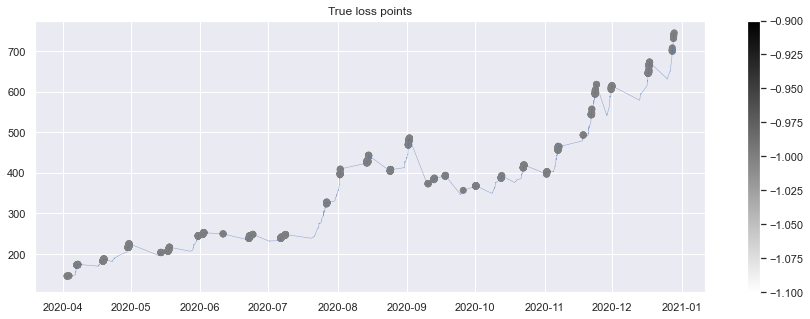

In [284]:
sc = y_true2.loc[y_true2==-1]
title = 'True loss points'
figure_scatter(sc,close.loc[y_true2.index],title,cmap='gray_r')

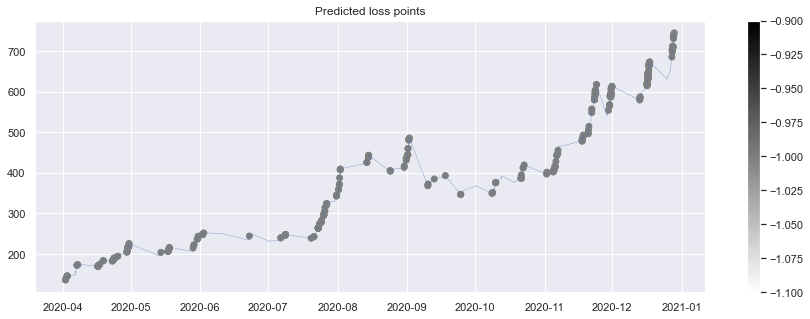

In [285]:
sc = y_pred2.loc[y_pred2==-1]
close_t=close.loc[y_true2.index]
title = 'Predicted loss points'
figure_scatter(sc,close_t,title,cmap='gray_r')

In [286]:
# After drop predicted loss
predlabel = y_true2.drop(index=y_pred2.loc[y_pred2==-1].index)
predlabel.value_counts()

 1.0    1039
-1.0     550
Name: y, dtype: int64

In [287]:
print('이익확률 pi: ',predlabel.value_counts().values[0] / predlabel.value_counts().values.sum())\

이익확률 pi:  0.6538703587161737


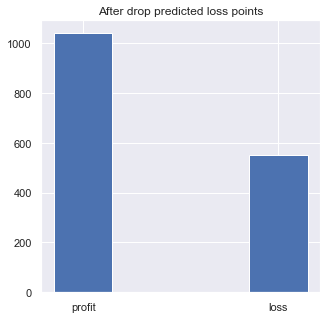

In [288]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],predlabel.value_counts(), width=0.3)
plt.title('After drop predicted loss points')
plt.savefig('image/pnl_2nd.png')
plt.show()

the pitfalls of maximizing precision score:

there can be huge diminish in bet opportunities.

Using Predicted Probabilities adjust it.
from 0.5 to maybe 0.75

In [289]:
y_pred_prob2 = predictor.predict_proba(test_data)
y_pred_prob2

,-1.0,1.0
timestamp,,
2020-04-02 00:15:00,0.084105,0.915895
2020-04-02 00:20:00,0.025197,0.974803
2020-04-02 00:25:00,0.188083,0.811917
2020-04-02 00:30:00,0.155125,0.844875
2020-04-02 00:40:00,0.205639,0.794361
...,...,...
2020-12-28 09:15:00,0.678718,0.321282
2020-12-28 09:20:00,0.536612,0.463388
2020-12-28 09:25:00,0.304556,0.695444


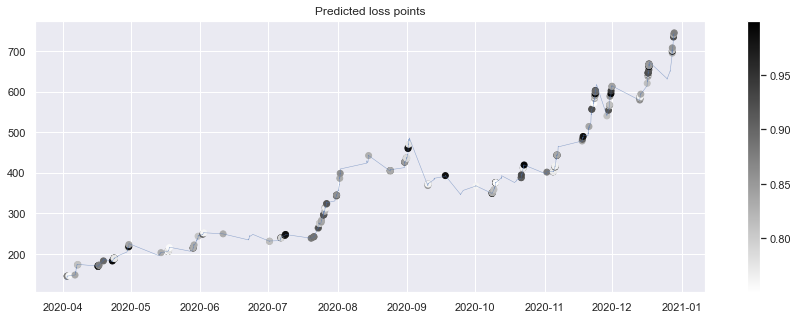

In [290]:
pred_loss = y_pred_prob2[-1]
sc = pred_loss.loc[pred_loss>0.75]
close_t=close.loc[y_true2.index]
title = 'Predicted loss points'
figure_scatter(sc,close_t,title,cmap='gray_r')

In [291]:
# After drop predicted loss
predlabel2 = y_true2.drop(index=y_pred_prob2.loc[y_pred_prob2[-1]>=0.75].index)
predlabel2.value_counts()

 1.0    1126
-1.0     595
Name: y, dtype: int64

In [292]:
print('이익확률 pi: ',predlabel2.value_counts().values[0] / predlabel2.value_counts().values.sum())\

이익확률 pi:  0.6542707728065078


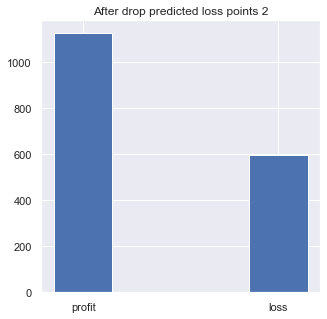

In [293]:
plt.figure(figsize=(5,5))
plt.bar(['profit','loss'],predlabel2.value_counts(), width=0.3)
plt.title('After drop predicted loss points 2')
plt.savefig('image/pnl_2nd2.png')
plt.show()

Solution (in process):

When choosing the optimal model, consider not only precision score but also the number of betting opportunities.

More specifically maximizing annualized Sharpe ratio.


see returns

In [294]:
finret = ret.loc[y_true2.index].drop(index=y_pred_prob2.loc[y_pred_prob2[-1]>=0.75].index)
finret

timestamp
2020-04-02 00:15:00    0.051778
2020-04-02 00:20:00    0.050457
2020-04-02 00:25:00    0.052732
2020-04-02 00:30:00    0.049944
2020-04-02 00:40:00    0.049651
                         ...   
2020-12-28 08:25:00   -0.051527
2020-12-28 09:15:00   -0.052281
2020-12-28 09:20:00   -0.052836
2020-12-28 09:25:00   -0.053338
2020-12-28 09:40:00   -0.051779
Name: ret, Length: 1721, dtype: float64

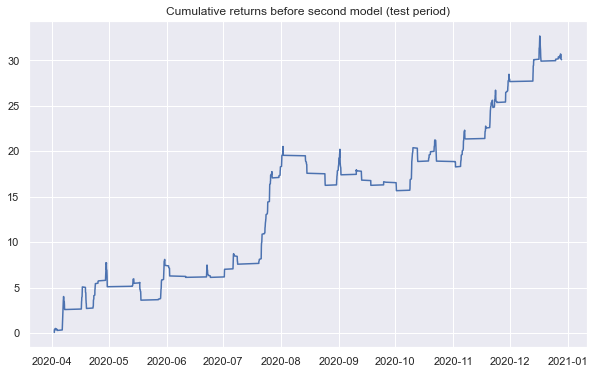

In [295]:
plt.figure(figsize=(10,6))
plt.title('Cumulative returns before second model (test period)')
plt.plot(ret.loc[y_true2.index].cumsum())
plt.savefig('image/cumsum_ret_1st_test.png')
plt.show()

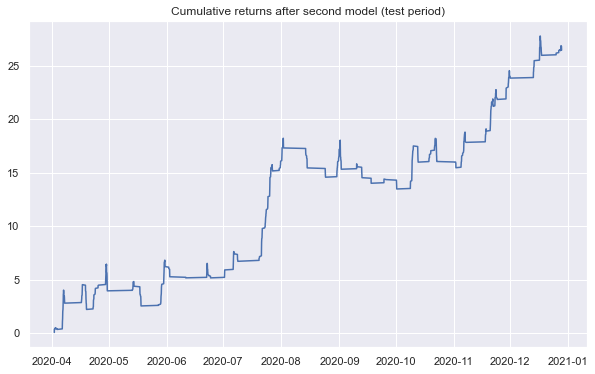

In [296]:
plt.figure(figsize=(10,6))
plt.title('Cumulative returns after second model (test period)')
plt.plot(finret.cumsum())
plt.savefig('image/cumsum_ret_2nd_test.png')
plt.show()

### 4.3. Trading

#### bet sizing

- Kelly rules
- Use predicted probabilities as bet confidence

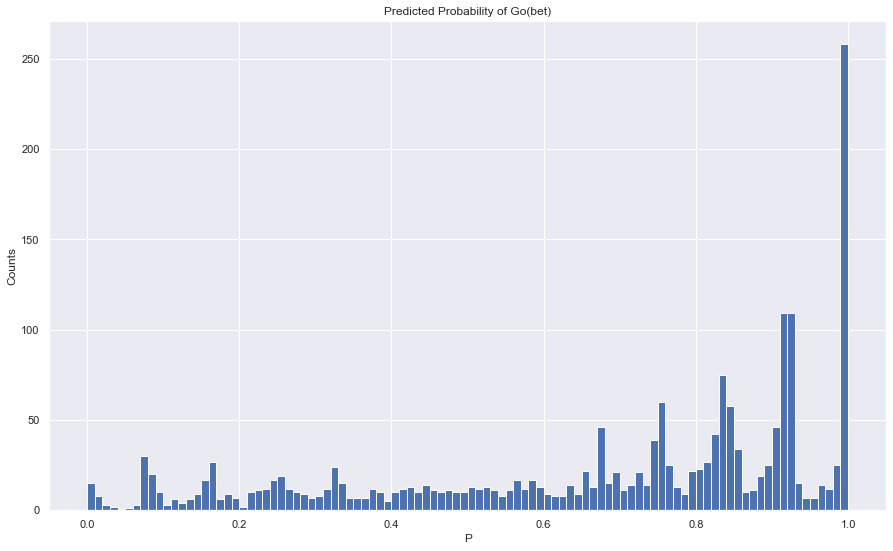

In [297]:
p = y_pred_prob2[1]
f=plt.figure(figsize=(15,9))
a = f.gca()
a.hist(p,bins=100)
plt.xlabel('P')
plt.ylabel('Counts')
plt.title('Predicted Probability of Go(bet)')
plt.savefig('image/predprob.jpg')
plt.show()

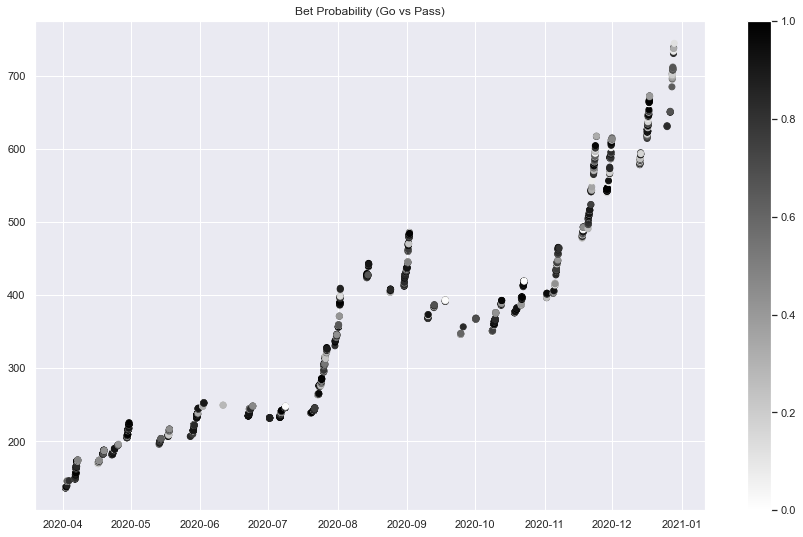

In [298]:
cmap = 'gray_r'

plt.figure(figsize=(15,9))
plt.scatter(y_true2.index, close.loc[y_true2.index] ,c= p, cmap=cmap,vmin=0,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet Probability (Go vs Pass)')
plt.savefig('image/bet_prob.png')
plt.show()

## Bet Sizing

In [299]:
def get_signal(prob, num_classes):
    if prob.shape[0] == 0:
        return pd.Series(dtype='float64')

    bet_sizes = (prob - 1/num_classes) / (prob * (1 - prob))**0.5

    bet_sizes = bet_sizes.apply(lambda s: 2 * norm.cdf(s) - 1)

    return bet_sizes

In [300]:
def discretize(signal0, step_size):
    signal1 = (signal0 / step_size).round() * step_size
    signal1[signal1 > 1] = 1  # Cap
    signal1[signal1 < -1] = -1  # Floor
    return signal1

In [301]:
prob = p.copy()

m = get_signal(prob, 2)
m = discretize(m, 0.25)

In [302]:
m

timestamp
2020-04-02 00:15:00    0.75
2020-04-02 00:20:00    1.00
2020-04-02 00:25:00    0.50
2020-04-02 00:30:00    0.75
2020-04-02 00:40:00    0.50
                       ... 
2020-12-28 09:15:00   -0.25
2020-12-28 09:20:00   -0.00
2020-12-28 09:25:00    0.25
2020-12-28 09:40:00   -0.25
2020-12-28 16:15:00   -0.75
Name: 1.0, Length: 1959, dtype: float64

In [303]:
m.loc[m[m<0].index] = 0
m

timestamp
2020-04-02 00:15:00    0.75
2020-04-02 00:20:00    1.00
2020-04-02 00:25:00    0.50
2020-04-02 00:30:00    0.75
2020-04-02 00:40:00    0.50
                       ... 
2020-12-28 09:15:00    0.00
2020-12-28 09:20:00   -0.00
2020-12-28 09:25:00    0.25
2020-12-28 09:40:00    0.00
2020-12-28 16:15:00    0.00
Name: 1.0, Length: 1959, dtype: float64

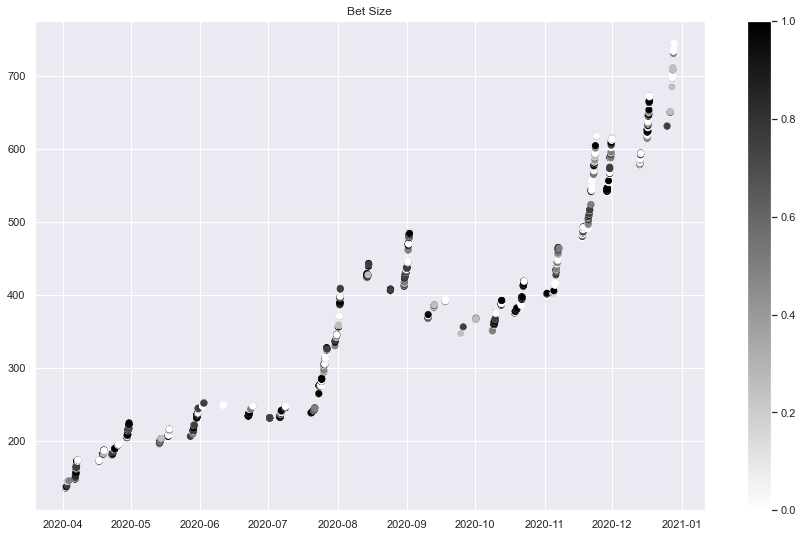

In [304]:
cmap = 'gray_r'

plt.figure(figsize=(15,9))
plt.scatter(y_true2.index, close.loc[y_true2.index] ,c= m, cmap=cmap,vmin=0,vmax=1)
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Bet Size')
plt.savefig('image/betsize.jpg')
plt.show()

## Results

### Backtest with zipline/pyfolio

We are not ready for the portfolio optimization.

Here, let us say there are only two assets (ETH and cash)

In [305]:
barrier_t = barrier.loc[y_true2.index]

In [306]:
initial_money=1_000_000
bet_size = m*initial_money

In [307]:
wallet = tb.get_wallet(close,barrier_t,initial_money, bet_size)
wallet

,exit,price,money_spent,money_receive,buy_amount,sell_amount,n_stock,cash_inventory
timestamp,,,,,,,,
2020-04-02 00:15:00,2020-04-02 16:55:00,136.24,102180000.0,0.000000e+00,750000.0,0.0,750000.0,-1.011800e+08
2020-04-02 00:20:00,2020-04-02 16:55:00,136.42,136420000.0,0.000000e+00,1000000.0,0.0,1750000.0,-2.376000e+08
2020-04-02 00:25:00,2020-04-02 16:55:00,136.11,68055000.0,0.000000e+00,500000.0,0.0,2250000.0,-3.056550e+08
2020-04-02 00:30:00,2020-04-02 16:55:00,136.49,102367500.0,0.000000e+00,750000.0,0.0,3000000.0,-4.080225e+08
2020-04-02 00:40:00,2020-04-02 16:55:00,136.53,68265000.0,0.000000e+00,500000.0,0.0,3500000.0,-4.762875e+08
...,...,...,...,...,...,...,...,...
2020-12-28 16:15:00,2020-12-29 03:35:00,744.38,0.0,1.116570e+09,0.0,1500000.0,2500000.0,3.234162e+09
2020-12-28 19:30:00,0,747.68,0.0,7.476800e+08,0.0,1000000.0,1500000.0,3.981842e+09
2020-12-29 03:55:00,0,700.00,0.0,1.750000e+08,0.0,250000.0,1250000.0,4.156842e+09


In [308]:
eth_position = wallet.money_spent-wallet.money_receive
cash_position = wallet.cash_inventory.diff()

In [309]:
positions = pd.DataFrame()
positions['ETH'] = eth_position
positions['cash'] = cash_position

In [310]:
positions

,ETH,cash
timestamp,,
2020-04-02 00:15:00,1.021800e+08,NaN
2020-04-02 00:20:00,1.364200e+08,-1.364200e+08
2020-04-02 00:25:00,6.805500e+07,-6.805500e+07
2020-04-02 00:30:00,1.023675e+08,-1.023675e+08
2020-04-02 00:40:00,6.826500e+07,-6.826500e+07
...,...,...
2020-12-28 16:15:00,-1.116570e+09,1.116570e+09
2020-12-28 19:30:00,-7.476800e+08,7.476800e+08
2020-12-29 03:55:00,-1.750000e+08,1.750000e+08


In [311]:
ret = barrier_t.ret
ret

timestamp
2020-04-02 00:15:00    0.051778
2020-04-02 00:20:00    0.050457
2020-04-02 00:25:00    0.052732
2020-04-02 00:30:00    0.049944
2020-04-02 00:40:00    0.049651
                         ...   
2020-12-28 09:15:00   -0.052281
2020-12-28 09:20:00   -0.052836
2020-12-28 09:25:00   -0.053338
2020-12-28 09:40:00   -0.051779
2020-12-28 16:15:00   -0.052172
Name: ret, Length: 1959, dtype: float64

In [312]:
#pyfolio only supports daily returns

ret_daily = ret.resample('D').sum()
positions_daily = positions.resample('D').sum()

In [314]:
#pf.create_full_tear_sheet(ret_daily, positions=positions_daily)